# LASSO Regresion on covid-19 cases in NYS

## Load modulues

In [27]:
%matplotlib widget
import os
import requests

import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn import linear_model
from scipy import stats as sps
from sklearn.feature_selection import SelectFromModel
from IPython.display import display

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

sns.set_style("whitegrid")
GAMMA = 1/7

## Important dates

In [22]:
# interventin dates
# 03/10/2020 school close in New Rochelle
# https://www.governor.ny.gov/news/during-novel-coronavirus-briefing-governor-cuomo-announces-new-mass-gatherings-regulations
# 03/12/2020 mass gathering reduced to 500 max. 50% occupancy


# 03/17/2020 close of gyms, restaurants and bars, movie theaters, mass gathering up to 50. https://www.governor.ny.gov/news/amid-lack-federal-direction-governor-cuomo-governor-murphy-and-governor-lamont-announce
bars = pd.to_datetime('03-16-2020 20:00', dayfirst=False)
# 03/18/2020 school clousure http://www.nysed.gov/news/2020/state-education-department-issues-updated-guidance-schools-regarding-novel-coronavirus
schools = pd.to_datetime('03-18-2020 20:00', dayfirst=False)

# https://www.governor.ny.gov/news/amid-ongoing-covid-19-pandemic-governor-cuomo-announces-deployment-1000-bed-hospital-ship-usns
# 03/20/2020 00:00 50% of the workforce
workforce_50 = pd.to_datetime('03-20-2020 20:00', dayfirst=False)
# 03/22/2020 20:00 ny_pause 
ny_pause = pd.to_datetime('22-03-2020 00:00', dayfirst=True)
# CDC masks https://www.npr.org/sections/goatsandsoda/2020/04/10/829890635/why-there-so-many-different-guidelines-for-face-masks-for-the-public
masks_cdc = pd.to_datetime('03-04-2020 00:00', dayfirst=True)
mask_employers = pd.to_datetime('12-04-2020 00:00', dayfirst=True)
mask_public = pd.to_datetime('17-04-2020 00:00', dayfirst=True)

events = [bars, schools, workforce_50, ny_pause, masks_cdc, mask_employers, mask_public]

## Get data

In [4]:
df = pd.read_csv('https://health.data.ny.gov/resource/xdss-u53e.csv/?$limit=5000', usecols=['test_date', 'total_number_of_tests', 'new_positives'])
df = df.rename(columns={'new_positives': 'Positives', 'total_number_of_tests': 'Tests', 'test_date': 'date'})
df['date'] = pd.to_datetime(df['date'])
df = df.groupby('date').sum()

df['Odds'] = df.Positives / (df.Tests - df.Positives)
df['Date'] = pd.to_datetime(df.index)
df = df[df['Date'] >= '2020-03-10']

df.head()

,Positives,Tests,Odds,Date
date,,,,
2020-03-10,44,425,0.115486,2020-03-10
2020-03-11,56,553,0.112676,2020-03-11
2020-03-12,102,762,0.154545,2020-03-12
2020-03-13,164,1290,0.145648,2020-03-13
2020-03-14,131,1293,0.112737,2020-03-14


## Plots

I we plot the number of positive tests we can see that the data is noisy.
But, if we take into account the number of people tested each day, the data looks way more clean.

In [23]:
plt.close('all')
ax = df.plot(y=['Positives', 'Tests'], secondary_y=['Tests'], legend=True)
plt.vlines(events, 0, df.Tests.max(), linestyle='--')
plt.tight_layout()
plt.savefig('figs/tests_and_cases.jpg', dpi=300)
plt.show()

plt.figure()
ax = sns.scatterplot(data=df, x='Date', y='Odds')
ax.set_yscale('log')
ax.set_xlim([df.Date.min(), df.Date.max()])
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Relationship between the total number of infected individuals and positive tests

As has been shown previously [[1]](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185), the number of new infected individuals in a given day $k_t$ is given by:
$$
k_t = k_{t-1} e^{(R_{t-1}-1)\gamma}
$$

where $R_t$ is the effective reproductuve number and $\gamma^{-1}$ is the infectious period estimated as 7 days accoring to [2].

The following derivation was suggested to my by Will Meierjurgen Farr on this GitHub [Issue](https://github.com/k-sys/covid-19/issues/45#issuecomment-623782130). 
Since we do not have access to the total number of infected indiviudals, but only to the population being tested, we have to use some statisticals assumtions on this populations.
If we asume that the people being tested, in a given day, is a sample of the population with COVID-19-like sympoms we can state that:

$$
n_{t} = [P_t(CV|sympoms) P_t(sympoms) +P_t(not CV|sympoms)P_t(sympoms)]Nf_t 
$$

where $n_{t}$ is the number of people tested, $P_t(CV|sympoms)$ is the probablity of a pacient being positive for coronavirus given that the she is sympomatic, $P_t(sympoms)$ is the probablity of having COVID-like sympoms, $P_t(not CV|sympoms)$ is the probability of a pacient being coronavirus negative given he has COVID-19-like sympoms, $N$ is the total population, and $f_t$ is the fraction of people with sympoms that is selected to be tested (this number can be different each day, for example if the number of tests availabes changes).
Also, note that the probability of a test being positive in a given day is $Positive_t=P_t(CV|sympoms) P_t(sympoms) N f_t$


Now, if we assume that $P_t(sympoms|CV)=cte$ we can use Bayes theorem to show that:

$$
P_t(CV|sympoms) P_t(sympoms) \propto P_t(CV) = \frac{k_t}{N}
$$

Then:
$$
P_t(CV|sympoms) P_t(sympoms) \propto k_t
$$

Finally, if we assume that $P_t(not CV|sympoms)P_t(sympoms)=cte$:
$$
Odds_t = \frac{P(CV|sympoms) P(sympoms)Nf_t}{P_t(not CV|sympoms)P_t(sympoms)Nf_t} \\
Odds_t = \frac{P(CV|sympoms) P(sympoms)}{P_t(not CV|sympoms)P_t(sympoms)} \\
Odds_t \propto k_t \\
$$

\begin{align}
Odds_t = Odds_{t-1} e^{(R_{t-1}-1)\gamma}
\label{eq:odds_rt}\tag{1}
\end{align}

We used three hypothesis. First, constant population $N$ (for $P_t \propto k_t$ and for the evolution of $k_t$). Second, that the tested population is a random sample from the population with COVID19-like sympoms ($n_t = [P_t(CV|sympoms) P_t(sympoms) +P_t(not CV|sympoms)P_t(sympoms)]Nf_t$) this is not the case when people is being tested based on contacts for example. And third, that $P_t(not CV|sympoms)P_t(sympoms)=cte$, this is equivalent to say that the number of people with covid-19-like sympoms but without the coronavirus (for example people with the flu) is constant, or at least it changes are negligible compared with the changes in the amount of sympomatic people with coronavirus.

## Linearization

Defining

$$
b_i =  e^{(R_{i-1}-1)\gamma}
\label{eq:bi_rt} \tag{2}
$$

We can write \ref{eq:odds_rt} as:

\begin{equation}
odd_i = b_{i-1} * odd_{i-1}
\label{eq:odds1} \tag{3}
\end{equation}

Now, instead of using $b_i$ as the parameters to estimate we decompose each $b$ as follows:

$$
b_i = \prod_{j=0}^{i} a_j
\label{eq:biai} \tag{4}
$$

Now, the $a_j$ represent the rate of change of the variable $b_i$. Next, we replace the \ref{eq:biai} in \ref{eq:odds1}
$$
odd_i = \prod_{j=0}^{i-1} a_j * odd_{i-1}\\
odd_i = \prod_{j=0}^{i-1} a_j * \prod_{j=0}^{i-2} a_j * odd_{i-2}\\
odd_i = \prod_{k=0}^{i-1}\prod_{j=0}^{k} a_j * odd_{0}\\
odd_i = \prod_{j=0}^{i-1} a_j^{i-j} * odd_{0}\\
$$

Now, we liniarize this result and we generalize it to the case where $i=0$ using the $max$ function:

$$
log(odd_i) = \sum_{j=0}^{max(i-1, 0)} (i-j)log(a_j)  +  log(odd_{0})
\label{eq:logodds}\tag{5}
$$

We can write \ref{eq:logodds} as a linear problem with the following definitions:

$$
y = X \beta + \beta_0
$$

$$
y_i = log(odd_i) \\
X_{i,i} = 
\begin{cases}
i-j & i \ge j \\
0   & i < j\\
\end{cases}\\
\beta_i =  log(a_i)
\label{eq:linear_system}\tag{6}
$$

Now if we apply a LASSO regression we will find the solution that minimize the following cost function

$$
Err = \sum (y-\hat{y})^2 + \alpha |\beta|_1
$$

Hopefully, this solution will be sparse which means that most of the $\beta_i$ will be $0$, and hence $a_i=1$.
This is equivalent to say that the $b_i$ are almost constant except at the values whete $a_i \neq 1$.



[1] Bettencourt, L. M. A., & Ribeiro, R. M. (2008). Real time bayesian estimation of the epidemic potential of emerging infectious diseases. PLoS ONE, 3(5). https://doi.org/10.1371/journal.pone.0002185

[2] Sanche, S., Lin, Y. T., Xu, C., Romero-Severson, E., Hengartner, N., & Ke, R. (2020). High Contagiousness and Rapid Spread of Severe Acute Respiratory Syndrome Coronavirus 2. Emerging Infectious Diseases, 26(7). https://doi.org/10.3201/eid2607.200282



## Classes

This cell contains the main class: LassoICSelector. Its main method is fit_best_alpha. It works as follows:
```
For each alpha value:
    1. Fits a lasso regression to the data
    2. Selectes the first non zero variable from each chunck
    3. Fits a linear regression with the selected variables
    4. Excludes all non sifgificative (p-value>0.05) variables and fits a linear model again

The linear model with less AIC from step 4 is selected.
```



In [17]:
class FirstInChunkSelector(object):
    '''Selects first element from each non zero chunk.'''

    def __init__(self, clf):
        self.clf = clf
        self.coef = None
        self.mask = None

    def select_coef(self):
        n_features = len(self.clf.coef_)
        no_zero = np.zeros(n_features+1)
        no_zero[1:] = self.clf.coef_ != 0
        self.mask = np.diff(no_zero)>0
        self.coef = self.clf.coef_[self.mask]
        return self.coef

    def transform(self, X):
        self.select_coef()
        return X[:, self.mask]

    def get_support(self):
        self.select_coef()
        return self.mask

    def get_number_of_features(self):
        self.select_coef()
        return sum(self.mask)


class LassoICSelector(object):
    """LASSO regression with FirstInChunk selector."""

    def __init__(self, X, y, criterion):
        self.lasso = linear_model.Lasso(alpha=0.1, max_iter=100000, tol=0.001)
        self.criterion = criterion
        self.selector = FirstInChunkSelector(self.lasso)
        self.OLS = sm.OLS
        self.ols = self.OLS(y, X)
        self.ols_results = None
        self.X = X
        self.y = y
        self.final_ols = False

    def transform_to_ols(self, X):
        '''Selects only the features of X are used by OLS.
        Also, adds a coloumn with ones for the intercept.
        '''

        X_new = self.selector.transform(X)
        if self.final_ols:
            X_new = X[:, self.support]
        X_new_with_cte = np.hstack([X_new, np.ones((X_new.shape[0], 1))])
        return X_new_with_cte

    def fit(self, X, y, alpha):
        # set alpha for lasso
        self.lasso.alpha = alpha

        # fit lasso
        self.lasso.fit(X, y)

        # select features
        X_new = self.transform_to_ols(X)

        # fit ols
        self.ols = self.OLS(y, X_new)
        self.ols_results = self.ols.fit()

        # remove non signicative variables and fit again
        mask = self.ols_results.pvalues < 0.05
        Xnew = self.transform_to_ols(X)
        Xnew = Xnew[:, mask]
        self.support = self.selector.get_support()
        self.ols = self.OLS(y, Xnew)
        self.ols_results = self.ols.fit()

        self.support[self.support] = mask[:-1]

    def fit_best_alpha(self, X, y, alphas):
        self.alphas_ = alphas
        self.criterions_ = np.zeros(len(self.alphas_))
        self.log_liklehods = np.zeros(len(self.alphas_))
        self.llfs = np.zeros(len(self.alphas_))

        for i, alpha in enumerate(self.alphas_):
            self.fit(X, y, alpha)
            self.criterions_[i], self.log_liklehods[i] = self.get_criterion(self.ols.exog, y)
            self.llfs[i] = self.ols_results.llf

        alpha = alphas[len(self.criterions_) - np.argmin(self.criterions_[::-1]) - 1]
        self.fit(X, y, alpha)
        self.final_ols = True

    def predict(self, X):
        '''Predicts y useing the OLS fit.'''

        return self.ols.predict(self.ols_results.params, X)

    def log_liklihood(self, X, y):
        '''Computes the log liklihood assuming normally distributed errors.'''

        eps64 = np.finfo('float64').eps

        # residuals
        R = y - self.predict(X)
        sigma2 = np.var(R)

        loglike = -0.5 * len(R) * np.log(sigma2)
        loglike -= 0.5 * len(R) * np.log(2*np.pi) - 0.5*len(R) + 0.5
        return loglike

    def get_criterion(self, X, y):
        '''Computes AIC or BIC criterion.'''

        n_samples = X.shape[0]
        if self.criterion == 'aic':
            K = 2  # AIC
        elif self.criterion == 'bic':
            K = np.log(n_samples)
        else:
            raise ValueError('criterion should be either bic or aic')

        log_like = self.log_liklihood(X, y)
        df = X.shape[1]

        aic = K * df - 2*log_like
        self.criterion_ = aic

        return self.criterion_, log_like

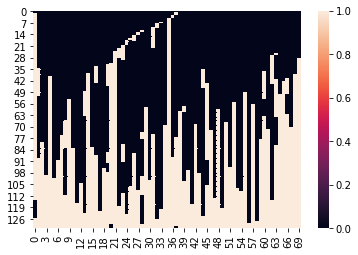

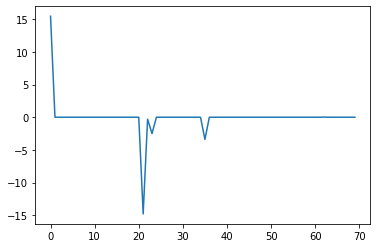

In [6]:
data = df.copy()

# create the independent and the dependent variables
y = np.log(data['Odds'])
X = np.tri(len(y))
X = np.cumsum(X, axis=0)[:, 1:]

lr = linear_model.LassoLars(alpha=0, max_iter=100000)
lr.fit(X, y)
sns.heatmap(lr.coef_path_.T!=0)
i =np.argmin((lr.alphas_-0.001)**2)
plt.figure()
plt.plot(lr.coef_path_[:,i])

## Fit
Now, we create the linear system and fit the model

In [18]:
# create the independent and the dependent variables
y = np.log(df['Odds'])
X = np.tri(len(y))
X = np.cumsum(X, axis=0)[:, 1:]

# create lasso instance
lics = LassoICSelector(X, y.values, 'bic')

# fit
alphas = np.logspace(-3, -1, 100)
lics.fit_best_alpha(X, y, alphas)

In [29]:
data = df.copy()

# use coefficients to calculate Rt
coef = np.zeros(len(data))
coef_std = np.zeros_like(coef) * np.nan
ind = np.squeeze(np.argwhere(lics.support))

# we do not use the last coefficient since it's the intercept (=log(odds_o))
coef[ind] = lics.ols_results.params[:-1]

# using equation 2, 4 and 6
data.loc[:, 'R'] = np.cumsum(coef)/GAMMA+1


# get covarinace matrix of coefficients
cov = lics.ols_results.cov_params().values

# since the values of R are a sum of variables we use the formula to calculate the variance of the sum of gaussian variables with a known covariance matrix 
stds = [np.sqrt(cov[:n, :n].sum()) for n in range(1, cov.shape[0])]

coef_std[ind] = stds
data.loc[:, 'Rstd'] = coef_std/GAMMA
data['Rstd'] = data['Rstd'].fillna(method='ffill')

data['R_l'] = data['R'] - 2*data['Rstd']
data['R_u'] = data['R'] + 2*data['Rstd']


# now we calculated the fitted curve and its error
yhat = lics.ols_results.fittedvalues


odds_hat = np.exp(yhat)
Xols = lics.transform_to_ols(X)
(yhat_std, yhat_l, yhat_u) = wls_prediction_std(lics.ols_results, Xols)
oddshat_std = odds_hat*yhat_std

data.loc[:, 'odds_hat'] = odds_hat
data.loc[:, 'oddshat_std'] = oddshat_std
data.loc[:, 'oddshat_l'] = odds_hat - 2*oddshat_std
data.loc[:, 'oddshat_u'] = odds_hat + 2*oddshat_std









plt.close('all')

plt.figure()
plt.plot(alphas, lics.criterions_)
plt.vlines(lics.lasso.alpha, min(lics.criterions_), max(lics.criterions_))
plt.title('alpha={}'.format(lics.lasso.alpha))
plt.ylabel('AIC')
plt.xlabel('Alpha')
plt.xscale('log')




plt.figure()
ax = data['R'].plot()
ax.fill_between(data.index, data['R_u'], data['R_l'],
                facecolor='blue', alpha=0.2, label='95% CI')
ax.set_xlim(data.index.min(), data.index.max())

ax.vlines(events, 0, data.R_u.max())

plt.ylabel('Rt')
plt.xlabel('Date')
plt.tight_layout()
plt.savefig('figs/RtL1.jpg', dpi=300)
plt.show()


plt.figure()
ax = sns.scatterplot(x='Date', y='Odds', data=data, label='Data')
ax = sns.lineplot(x='Date', y='odds_hat', label='Fit', ax=ax, data=data)
ax.fill_between(data.index, data['oddshat_l'],
                data['oddshat_u'],
                facecolor='blue', alpha=0.1, label='95% CI')

ax.legend()
ax.set_yscale('log')

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

plt.ylabel('Odds')
plt.tight_layout()
ax.set_xlim(data['Date'].min(), data.loc[data.odds_hat.notna(), 'Date'].max())
plt.savefig('figs/OddsL1.png')
plt.savefig('figs/OddsL1.jpg', dpi=300)
plt.show()

r_index = data.R.diff() != 0
r_index &= data.R.notna()
Rts = data.loc[r_index, ['R', 'R_l', 'R_u']]
display(Rts)
lics.ols_results.summary()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

,R,R_l,R_u
date,,,
2020-03-10,1.946318,1.846228,2.046407
2020-03-22,1.716181,1.578934,1.853427
2020-03-29,0.755429,0.705327,0.805530
2020-04-14,0.481780,0.459978,0.503582


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Odds   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     1236.
Date:                Thu, 21 May 2020   Prob (F-statistic):           2.96e-61
Time:                        11:22:35   Log-Likelihood:                 58.759
No. Observations:                  71   AIC:                            -107.5
Df Residuals:                      66   BIC:                            -96.20
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1352      0.007     18.909      0.000       0.121       0.149
x2            -0.0329      0.015     -2.135      0.036      -0.064      -0.002
x3            -0.1373      0.012    -11.092      0.000      -0.162      -0.113
x4            -0.0391      0.005     -8.388      0.000      -0.048      -0.030
const         -2.3258      0.056    -41.744      0.000      -2.437      -2.215
==============================================================================
Omnibus:                       10.077   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               17.317
Skew:                          -0.433   Prob(JB):                     0.000174
Kurtosis:                       5.259   Cond. No.                         254.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

date                                    
2020-03-15  2.047101  1.870700  2.223502
2020-03-22  1.663516  1.531065  1.795967
2020-03-29  0.758395  0.713824  0.802966
2020-04-14  0.483135  0.463122  0.503148

In [13]:
data.tail(30)

,Positives,Tests,Odds,Date,odds_hat,oddshat_std,oddshat_l,oddshat_u,R,Rstd,R_l,R_u
date,,,,,,,,,,,,
2020-04-20,4178,15464,0.370193,2020-04-20,0.371361,0.041632,0.288097,0.454625,0.48178,0.010901,0.459978,0.503582
2020-04-21,5526,20657,0.365210,2020-04-21,0.344861,0.038592,0.267677,0.422045,0.48178,0.010901,0.459978,0.503582
2020-04-22,6244,25938,0.317051,2020-04-22,0.320253,0.035781,0.248692,0.391814,0.48178,0.010901,0.459978,0.503582
2020-04-23,8130,34736,0.305570,2020-04-23,0.297400,0.033180,0.231040,0.363761,0.48178,0.010901,0.459978,0.503582
2020-04-24,10553,46912,0.290245,2020-04-24,0.276179,0.030775,0.214629,0.337728,0.48178,0.010901,0.459978,0.503582
2020-04-25,5902,27782,0.269744,2020-04-25,0.256471,0.028549,0.199373,0.313570,0.48178,0.010901,0.459978,0.503582
2020-04-26,3951,20745,0.235263,2020-04-26,0.238170,0.026490,0.185191,0.291150,0.48178,0.010901,0.459978,0.503582
2020-04-27,3110,18899,0.196973,2020-04-27,0.221175,0.024584,0.172008,0.270342,0.48178,0.010901,0.459978,0.503582
2020-04-28,4585,27487,0.200201,2020-04-28,0.205392,0.022819,0.159754,0.251031,0.48178,0.010901,0.459978,0.503582


## Extrapolation

In [11]:

n = 22



Xf = np.repeat([np.arange(1, X.shape[1]+1)[::-1]], n, axis=0)
Xf += np.arange(n).reshape(n, 1)
Xf = lics.transform_to_ols(Xf)
yhat_extrapolation = lics.ols.predict(lics.ols_results.params, Xf)
odds_hat_extrapolation = np.exp(yhat_extrapolation)
(yhat_std, yhat_l, yhat_u) = wls_prediction_std(lics.ols_results, Xf)
oddshat_std = odds_hat_extrapolation*yhat_std
extrapolation = pd.DataFrame({'oddshat_extrapolation_std': oddshat_std,
                              'odds_hat_extrapolation': odds_hat_extrapolation
                              },
                             index=data.index.shift(n-1, freq='D')[-n:])
extrapolation = pd.merge(data, extrapolation, how='outer', left_index=True,
                right_index=True)

In [11]:
lics.ols_results.params

x1       0.149586
x2      -0.054798
x3      -0.129303
x4      -0.039323
const   -1.704790
dtype: float64

In [10]:
sum(data.loc[~data['phat_extrapolation'].isna(), 'phat_extrapolation']*30000 + 2*data.loc[~data['phat_extrapolation'].isna(), 'phat_extrapolation_std']*30000)+data['cases'].sum()

366974.7139506621

## Counterfactual (what if)

1. Waht if the final step in Rt had not happened

In [14]:
fitted_params = lics.ols_results.params.copy()
current_palette = sns.color_palette()
for i in range(1, 4):
    params_cf = lics.ols_results.params.copy()
    params_cf[i] = 0
    lics.ols_results.params = params_cf
    yhat = lics.predict(lics.transform_to_ols(X))
    odds_cf = np.exp(yhat)
    (yhat_std, yhat_l, yhat_u) = wls_prediction_std(lics.ols_results, lics.transform_to_ols(X))
    oddshat_std = odds_cf*yhat_std

    lics.ols_results.params = fitted_params
    ratio_cf = odds_cf / (odds_cf+1)

    coef = np.zeros_like(lics.lasso.coef_)
    coef[lics.support] = params_cf[:-1]
    data.loc[data.cases.notna(), 'R_cf_{}'.format(i)] = np.cumsum(coef)/GAMMA+1

    data.loc[data.cases.notna(), 'Odds CF {}'.format(i)] = odds_cf

    data.loc[data.cases.notna(), 'oddshat_l_cf_{}'.format(i)] = odds_cf - 2*oddshat_std
    data.loc[data.cases.notna(), 'oddshat_u_cf_{}'.format(i)] = odds_cf + 2*oddshat_std

    data.loc[data.cases.notna(), 'ratio_cf_{}'.format(i)] = ratio_cf

plt.figure()
ax = sns.scatterplot(x='Date', y='Odds', data=data, label='Data', c=np.array([current_palette[0]]))
for i in range(1, 4):
    print(i, current_palette[i])
    ax = sns.lineplot(x='Date', y='Odds CF {}'.format(i), data=data, ax=ax, palette=[current_palette[i]], label='Odds CF {}'.format(i))
    print(i, current_palette[i])
    ax.fill_between(data.index, data['oddshat_l_cf_{}'.format(i)],
                    data['oddshat_u_cf_{}'.format(i)],
                    alpha=0.1)

plt.yscale('log')
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.grid(True)
plt.ylabel('Odds')
ax.set_xlim(data['Date'].min(), data.loc[data.odds_hat.notna(), 'Date'].max())
plt.tight_layout()
plt.savefig('figs/odds_cf.jpg')
plt.show()

plt.figure()
data.plot(y=['R', 'R_cf_1', 'R_cf_2', 'R_cf_3'], grid=True)
plt.savefig('figs/R_cf.png')
plt.tight_layout()



ValueError: Must have equal len keys and value when setting with an iterable

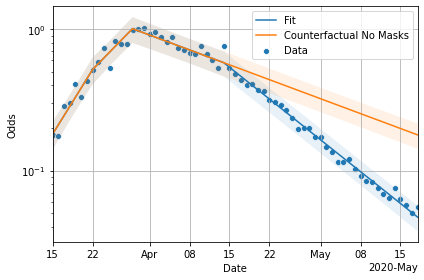

In [15]:
fitted_params = lics.ols_results.params.copy()
current_palette = sns.color_palette()

i = 3

params_cf = lics.ols_results.params.copy()
params_cf[i] = 0
lics.ols_results.params = params_cf
yhat = lics.predict(lics.transform_to_ols(X))
odds_cf = np.exp(yhat)
(yhat_std, yhat_l, yhat_u) = wls_prediction_std(lics.ols_results, lics.transform_to_ols(X))
oddshat_std = odds_cf*yhat_std

lics.ols_results.params = fitted_params
ratio_cf = odds_cf / (odds_cf+1)

coef = np.zeros(data.cases.notna().sum())#np.zeros_like(lics.lasso.coef_)
ind = np.squeeze(np.argwhere(lics.support))
coef[ind] = params_cf[:-1]
data.loc[data.cases.notna(), 'R_cf_{}'.format(i)] = np.cumsum(coef)/GAMMA+1

data.loc[data.cases.notna(), 'Odds CF {}'.format(i)] = odds_cf

data.loc[data.cases.notna(), 'oddshat_l_cf_{}'.format(i)] = odds_cf - 2*oddshat_std
data.loc[data.cases.notna(), 'oddshat_u_cf_{}'.format(i)] = odds_cf + 2*oddshat_std

data.loc[data.cases.notna(), 'ratio_cf_{}'.format(i)] = ratio_cf

plt.figure()
ax = sns.scatterplot(x='Date', y='Odds', data=data, label='Data', c=np.array([current_palette[0]]))

ax = sns.lineplot(x='Date', y='odds_hat', data=data, ax=ax, palette=[current_palette[i]], label='Fit')
ax.fill_between(data.index, data['oddshat_l'],
                data['oddshat_u'],
                alpha=0.1)

ax = sns.lineplot(x='Date', y='Odds CF {}'.format(i), data=data, ax=ax, palette=[current_palette[i]], label='Counterfactual No Masks')
ax.fill_between(data.index, data['oddshat_l_cf_{}'.format(i)],
                data['oddshat_u_cf_{}'.format(i)],
                alpha=0.1)

plt.yscale('log')
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.grid(True)
plt.ylabel('Odds')
ax.set_xlim(data['Date'].min(), data.loc[data.odds_hat.notna(), 'Date'].max())
plt.tight_layout()
plt.savefig('figs/odds_cf_masks.jpg', dpi=300)
plt.show()

#plt.figure()
#data.plot(y=['R', 'R_cf_1', 'R_cf_2', 'R_cf_3'], grid=True)
#plt.savefig('figs/R_cf.png')
#plt.tight_layout()



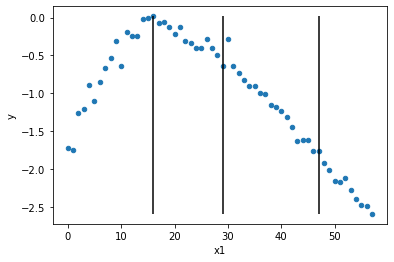

In [85]:
pepe = data['Odds']
pepe = pepe.reset_index()['Odds'].reset_index()
pepe = pepe.rename(columns={'index': 'x1', 'Odds': 'y'})
pepe['y'] = np.log(pepe['y'])
pepe = pepe[pepe.y.notna()]
pepe.to_csv('odds.csv', index=False)
pepe.plot.scatter(x='x1', y='y')
plt.vlines([16, 29, 47], pepe.y.min(), pepe.y.max())

In [82]:
print(data.index[0], data.index[16], data.index[29], data.index[47])
# 2020-03-15  2.050286  1.879760  2.220813
# 2020-03-23  1.652766  1.524404  1.781127
# 2020-03-30  0.772424  0.727664  0.817184
# 2020-04-15  0.463030  0.436574  0.489486

2020-03-15 00:00:00 2020-03-31 00:00:00 2020-04-13 00:00:00 2020-05-01 00:00:00


In [45]:
zy = (y-y.mean()) / y.std()
zx = (X-X.mean(axis=0, keepdims=True))/ X.std(axis=0, keepdims=True)
rho = np.dot(zy, zx)/len(zy)
rho2 = rho**2
np.argmax(rho2)
np.argsort(rho2)[::-1]
#y.index[31]

array([31, 30, 32, 29, 33, 28, 34, 27, 35, 26, 25, 36, 24, 37, 23, 38, 22,
       39, 21, 20, 40, 19, 41, 18, 17, 42, 16, 43, 15, 14, 44, 13, 45, 12,
       11, 46, 10,  9, 47,  8,  7,  6, 48,  5,  4,  3,  2,  1,  0, 49, 50,
       51, 52, 53, 54, 55, 56])

In [16]:
data[['positivityOdds', 'odds_hat', 'counterfactual_odds']]

,positivityOdds,odds_hat,counterfactual_odds
date,,,
2020-03-15,0.179050,0.181651,-1.705669
2020-03-16,0.174545,0.211053,-1.555644
2020-03-17,0.284707,0.245215,-1.405618
2020-03-18,0.298364,0.284907,-1.255593
2020-03-19,0.411207,0.331023,-1.105567
...,...,...,...
2020-05-16,NaN,NaN,NaN
2020-05-17,NaN,NaN,NaN
2020-05-18,NaN,NaN,NaN
